## Permutations on Block Matrices

This is pretty straight forward. We are dealing here with a class of boolean matrices $\mathcal{B}$ that are equivalent by permutations to a block diagonal matrix (blocks of 1s).
This means $A \in \mathcal{B}$, if and only if there exists a permutation matrix $P$, such that $C = P^{t} \cdot A \cdot P$ is a block diagonal matrix.
In this case we will also say that $A \equiv C$ (by permutations. 

Not that $A \cdot P$ means permuting the columns of $A$m according to $P$, and $P^{t} \cdot A$ means permuting the rows of $A$ in the same permutation that $P$ define if we look at it as a column permutation. So the operation $P^{t} A P$ is equivalent to re-indexing.

Another thing to consider is for any permutation matrix $P^{t} = P^{-1}$. lets identify the permutation matrix $P$ with the corresponding column permutation $\pi$.
Recall that any permutation can be expressed as a composition of 2-cycles: $\pi = \prod_1^k a_i$, so correspondingly $P = \prod_1^n A_i$.
Recall also that a 2-cycle is its own inverse.
This confirms that $P^t = \prod_n^1 A_i^t = \prod_n^1 A_i^{-1} = P^{-1}$ (and note the order change). So $P^t A$ is like doing the 2-permutations of $p$ on the rows and in the reverse order.


Now lets look at a block matrix and what permutations do and don't to it.


In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from functools import reduce


def blockMatrix(blocks):
    """creates a bloack 0-1 matrix.
    param blocks: list of non-negative integers which is the size of the blocks.
    a 0 block size corresponds to a 0 on the main diagonal.
    """
    blocks = np.array(blocks).astype("int64")
    f = lambda x: 1 if x == 0 else x
    n = np.sum([f(x) for x in blocks])
    n = int(n)
    A = np.zeros((n, n))
    pos = 0
    for i in range(len(blocks)):
        b = blocks[i]
        if b > 0:
            A[pos : pos + b, pos : pos + b] = np.ones((b, b))
        pos += f(b)
    return A


def permutationMatrix(ls):
    """returns a permutation matrix of size len(ls)^2.
    param ls: should be a reordering of range(len(ls)), which defines the
    permutation on the ROWS.
    returns a permutation matrix P.
    np.dot(P,A) should be rearrangement of the rows of A according to P.
    To permute the columns of a matrix A use:
    Q = np.transpose(P), then: np.dot(A,Q).
    """
    n = len(ls)
    P = np.zeros((n, n))
    for i in range(n):
        P[i, ls[i]] = 1
    return P


def shuffleCopyMatrix(lins, louts, msize):
    """Returns a matrix P that represents switch and copy operations
    on the rows of a matrix.
    param msize: the size (of the square matrix).
    param lins: row indices to be replaced.
    param louts: row that replace the ones listed in lins.
    lins and louts must be of the same length and contain indiced within
    range(msize).
    These operations are performed on the identity matrix, and the result
    is the return value P.
    """
    # P = np.zeros((msize,msize))
    P = np.identity(msize)
    I = np.identity(msize)
    if not len(lins) == len(louts):
        return P
    for i in range(len(lins)):
        P[lins[i]] = I[louts[i]]
    return P


def scoreMatrix(n):
    """The score function of the matrix. The assumption is that the true
    arrangement maximized the interaction close to the main diagonal.
    The total sum of the interaction is an invariant, preserved by permuations.
    param n: size of ca 2-d n over n array.
    returns the score matrix, which is used to calculate the score of any given
    n^2 matrix.
    """
    s = np.arange(n)
    s = np.exp(-s)
    S = np.zeros((n, n))
    for i in range(n):
        S[i][i:] = s[: n - i]
    return S


def score(A, S):
    """returns the weighted sum (by the score matrix S) of
    the matrix A
    """
    return np.sum(A * S)

def constrainMatrix(ls, A):
    """Returns a matrix of the same dimension as A, but every entry with
    an index (either row or column) not in ls is 0.
    """
    B = np.zeros_like(A)
    #B[np.ix_(ls,ls)] = 1
    B[np.ix_(ls,ls)] = A[np.ix_(ls,ls)]
    #B[ls][:,ls] = A[ls][:,ls]
    return B

def resetIndices(ls, A):
    """essentially returns the constraint of A to the complement indices of ls,
    by reseting all the indices in ls to 0.
    """
    B = A.copy()
    B[ls,:] = 0
    B[:,ls] = 0
    return B


def reindexMatrix(iss, jss, A):
    """iss and jss are lists of indices of equal size, representing
    a permuation: iss[i] is replaced with jss[i]. all other indices which are
    not in the lists left unchanged.
    """
    n = len(A)
    B = np.zeros_like(A)
    tss = [i for i in range(n)]
    for i in range(len(iss)):
        tss[iss[i]] = jss[i]
    for i in range(n):
        for j in range(n):
            B[i, j] = A[tss[i], tss[j]]
    return B

def scorePair(iss, jss, refmat, scoremat):
    A = np.zeros_like(refmat)
    l = iss + jss
    n = len(l)
    for i in range(n):
        for j in range(n):
            A[i, j] = refmat[l[i], l[j]]
    return score(A, scoremat)


def scorePair2(iss, jss, refmat):
    """scores the interaction of two segments
    iss and jss. weighted by the ideal diagonal distribution.
    """
    s = 0
    temp = 0
    for i in range(len(iss)):
        for j in range(len(jss)):
            temp = np.exp(-np.abs(j + len(iss) - i))
            # we only care about interaction between the 2 segments and not
            # inside each one of them which wouldn't be affected by
            # rearrangement.
            s += refmat[iss[i], jss[j]] * temp
    return s

def scorePair3(iss, jss, refmat, lreverse=False, rreverse=False):
    """iss, jss must be lists of segments of the index range of refmat,
    our reference matrix.
    reurns the interaction score of iss and jss as if reindexed the matrix so
    that they will be adjuscent to each other.
    """
    s = 0
    temp = 0
    for i in range(len(iss)):
        for j in range(len(jss)):
            x = iss[i]
            y = jss[j]
            if lreverse:
                x = iss[-1 - i]
            if rreverse:
                y = jss[-1 -j ]
            # temp = np.exp(-np.abs(i-j))
            #temp = np.exp(-np.abs(x - y))
            temp = np.exp(-np.abs(j + len(iss) - i))
            # we only care about interaction between the 2 segments and not
            # inside each one of them which wouldn't be affected by
            # rearrangement.
            s += refmat[x, y] * temp
    return s


# and the corrsponding indices are:
def articulate(l):
    """l is a list of positive integers.
    returns the implied articulation, meaning a list of lists (or 1d arrays)
    ls, such that ls[0] it the numbers 0 to l[0]-1, ls[1] is a list of the
    numbers ls[1] to ls[2]-1 etc.
    """
    # ls = [np.arange(l[0]).astype('uint64')]
    ls = []
    offsets = np.cumsum([0] + l)
    for i in range(0, len(l)):
        xs = np.arange(l[i]).astype("uint64") + offsets[i]
        ls.append(xs)
    return ls

def flip1(s, A, arts):
    """flips (reverses) the s'th segment, as listed by arts.
    returns new matrix.
    param s: the segment to flip.
    param A: the matrix.
    param arts: the articulation of A.
    """
    myarts = arts.copy()
    myarts[s] = np.flip(myarts[s])
    B = reindexMatrix(arts[s], myarts[s], A)
    return B


def indexing(arts):
   return reduce(lambda x,y: x + list(y), arts, [])

def swap2(s, r, A, arts):
    """swaps segments s and r, and returns the new
    matrix and the new segmentation.
    """
    myarts = arts.copy()
    myarts[s] = arts[r]
    myarts[r] = arts[s]
    B = reindexMatrix(indexing(arts), indexing(myarts), A)
    newarts = articulate([len(x) for x in myarts])
    return newarts, B

def improve(A, xs):
    """param: A: matrix.
    param xs: associated articulation.
    checks if segments 0 and 1 should be attached in some particular order.
    """
    if len(xs) == 1:
        return xs, A
    iss = xs[0]
    jss = xs[1]
    # we're going to see if iss and jss belong together in some configuration
    sl = scorePair3(iss,jss, A)
    slrv = scorePair3(iss,jss, A, lreverse=True)
    sr = scorePair3(jss,iss, A)
    srrv = scorePair3(jss,iss, A, rreverse=True)
    t = np.max([sl, slrv, sr, srrv])
    mysegs = [len(xs[i]) for i in range(1, len(xs))]
    mysegs[0] += len(xs[0])
    mysegs = articulate(mysegs)
    if t == 0:
        return xs, A
    if t == sl:
        # nothin to change
        return mysegs, A
    elif t == sr:
        # swap 0 and 1 segments
        _, B = swap2(1,0, A, xs)
        return mysegs, B
    elif t == slrv:
        # first flip the segment 0
        B = flip1(0, A, xs)
        return mysegs, B
    else:
        # first flip the segment 0
        B = flip1(0, A, xs)
        # then make the switch
        _, B = swap2(1,0, B, xs)
        return mysegs, B


    


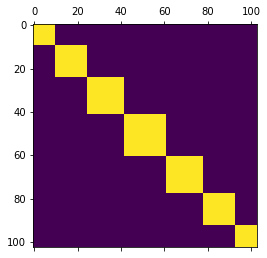

In [2]:
myblocks = [10,15,17,19,17,15,10]
mymatrix = blockMatrix(myblocks)

plt.matshow(mymatrix)


We now define a distribution (well sort of, not normalized) on the $103 \times 103$ matrix. We would like for cells close to the diagonal to have a high chances of being $1$ and the further the cell if from the main diagonal, it is exponentially less likely for it to be $1$. So $P(A[i,j] = 1) \propto e^{-|i-j|}$

The plots below show this distribution and also how it looks in log scale.

Text(0.5, 1.0, 'log scale')

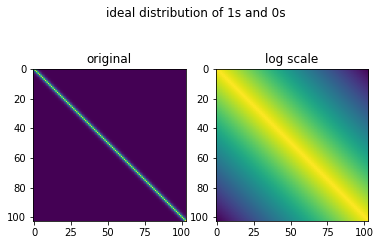

In [3]:
dmatrix = scoreMatrix(len(mymatrix))
dmatrix += np.transpose(dmatrix)
dmatrix -= np.identity(len(dmatrix))


fig, axs = plt.subplots(nrows=1, ncols=2)
fig.suptitle('ideal distribution of 1s and 0s')

axs[0].imshow(dmatrix)
axs[0].set_title('original')
axs[1].imshow(np.log(dmatrix))
axs[1].set_title('log scale')


we call this distribution matrix $S$, and let $A$ be any boolean matrix that is equivalent by permutations to some block diagonal matrix $B$.
We define the score of $A$ to be $s(A) = \sum_{i,j} A_{i,j}S_{i,j} = \sum_{i,j} A_{i,j}\exp-|i-j|)$

Theorem: If $A$ and $B$ as above, then $s(A) \leq s(B)$ and $s(B) = s(A)$ if and only if $A$ is itself a block matrix which is a permutation on the blocks of $B$ (and inside a block, any permutation
of its indices as well).
proof: pretty straight forward by induction.



Sow lets assume that we are only given the matrix $A$. We know it is equivalent by permutations to some unknown block matrix $B$. How easy is it to reach $B$ from $A$?

So first recall that any permutation on the blocks of $B$ would result in a matrix of the same, maximal score. We don't necessarily know how to distinguish between such matrices.

Our indices run from $0$ to $n-1$ ($n=103$ in our particular sampple). Every block diagonal matrix can be defined by a consequetive list of the block sizes on its diagonal (look for example that the python code above). So lets say that $B = \text{blcks}_{i = 0}^k(b_i)$ (the sum of the $b_i$'s add up to $n$ - the number of $b_i$ which are $0$ (which represent a $0$ on the diagonal).

Lets say that $I = [0,n)$ (our index range) and the blocks of $B$ can be designated by $I = \cup_1^k I_i = \cup_i [x_i, y_i) = \cup_i [x_i, x_i+b_i)$
(where $0= x_0 < x_1 < \dots x_i < x_{i+1} \dots x_n = n - b_n$)

Now lets consider a different segmentation $\sigma(I) = {[u_i,v_i)}$ of $I$: $I = \cup_0^l J_i = \cup_j [u_j, v_j)$ where $0=u_0 < v_0=u_1 < \dots$

We require from the segmentation $\sigma(I)$ to satisfy the following conditions:
1) If $u_j \in [x_i,y_i) = I_i$ then $v_j \notin I_i$.
2) IF $u_j = x_i$ for some $i$, then $\forall i v_j \neq y_i$
3) IF $v_j = y_i$ for some $i$, then $\forall i u_j \neq x_i$
4) for just the two end segments, we may allow them to be a prefix of the first block or a suffix of the last bloack, and then all the internal segments
    must be starting and ending inside a block and not at its exact ends.

To explain this in words, every segment $J_j$ cannot be contained completely inside just one interval $I_i$, and in addition no segment $J-j$ is a exactly the union of several consequetive intervals.

This type of segmentation ensures that every segment $J_j$ interacts with at least one of $J_{j-1}$ or $J_{j+1}$ where by interacting we mean there is some $s \in J_{i}$ and $t \in J_{i+1}$ and some $r \in \{0 \dots n\}$ such that $s,t \in I_r$ and therefore $A[s,t] = 1$.
Moreover, it follows from our requirement from segmentations that $J_i$ and $J_j$ have $0$ interaction if $|i-j| > 1$. 


So now suppose that we know that matrix $A$ was obtained by permutations from $B$ that are of two types:
1) permuting the order of the segments $\pi(J) = \{J_{\pi(i)}\}$, and
2) reversing some of the segments: $J_i \to \text{rev}(J_i)$.
And we are given not just $A$ but also a list of numbers that represent segments (which were obtained from the segmentation $J$).
In other words we have a segmented partition $K = \cup_1^l K_i = \cup [c_i,d_i)$ which was obtained from the segmentation $J$ by performing the permutations as explained above and then renaming the indices to $0 \dot n-1$. 

Even after this rearrangement it still holds that $K_i$ will interact with one or two and not more segments $K_x, K_y$ and these will be segments that correspond to a conseqetive 3 neighboring segements in the original segmentation $J$.

The strongest interaction (according to our ideal distribution) will happen if we stitch two such interacting $k$-segments in the right order (as it will be closest to the diagonal.
This allows us to reconstruct the original matrix in a very simple way:
while the number of segments is greater than 1:
* pick a segment
* find the segment with the strongest interaction with it
* stitch them together and re-index the indices to reflect the reordering and possibly reverse operations that is required. reducing the number of segments by 1
* repeat

I haven't provided the exact definition of 'strongest interaction', will do it later. But this is basically how it goes:
for two arbitraru segments $X = [a, a+1, \dots, a+x)$ and $Y = [y, y+1, \dots y+b)$, we define a score function with respect to the matrix $A$ as follows:
$s(X,Y) = \sum_{i =0}^{x-1} \sum_{j = 0}^{y-1} A[X[i], Y[j]] \exp(-|i-j|)$

In general $s(X,Y) \neq s(Y,X)$. And we also allow reverse, so if $Y^r$ is the reverse of $Y$, let $A|_{Y^r}$ be the resulting matrix from $A$ after reindexing according to $Y^r$.
Then $s(X,Y^r)$ is the same formula as above but replacing $A$ with $A|_{Y^r}$.

In the algorithm above, to find a neighbor of $X$ to join with it, we find the one or two interaction partners $Y,Z$, and pick the one (or its reverse) that maximized:
$s(X,Y), s(Y,X), s(Y^r, X), S(X, Y^r), s(X,Z), \dots$. 8 combinations in total. We actually go over all the segments but these are the only combination which will possibly be non-zero.

## An example

We shall construct this block matrix:


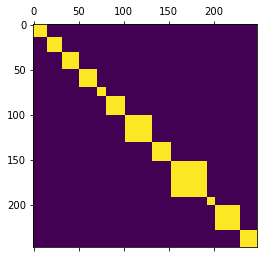

In [4]:
# a bigger experiment

fooblocks = [15,17,19,20,10,21,30,21,40,9,27,19]
foo = blockMatrix(fooblocks)

np.sum(fooblocks)

foosegs = [38, 34, 32, 38, 37, 34, 35]
np.sum(foosegs)
np.sum(fooblocks)

foosegs = articulate(foosegs)


plt.matshow(foo)


perform some swaps and flips and keep track of the segmentation


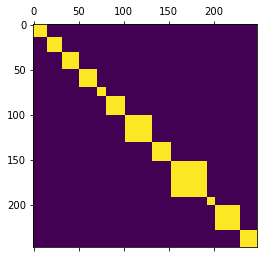

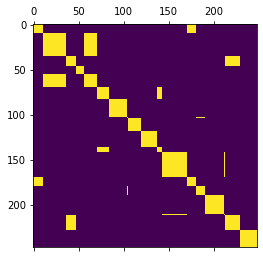

In [11]:
# now perform some flips and swaps
bar = flip1(0, foo, foosegs)
bar = flip1(1, foo, foosegs)
bar = flip1(5, foo, foosegs)
barsegs, bar = swap2(0,3, bar, foosegs)
barsegs, bar = swap2(1,2, bar, barsegs)
barsegs, bar = swap2(5,2, bar, barsegs)
barsegs, bar = swap2(4,0, bar, barsegs)
barsegs, bar = swap2(5, 1, bar, barsegs)
barsegs, bar = swap2(1,2, bar, barsegs)

plt.matshow(foo)
plt.matshow(bar)


Text(0.5, 1.0, 'reconstructed')

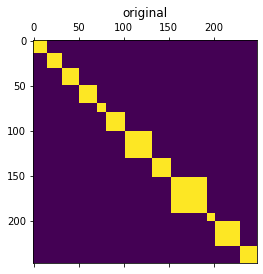

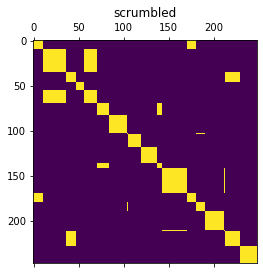

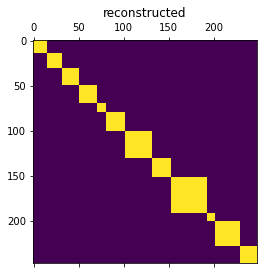

In [12]:
oldbar = bar.copy()

# reconstruction procedure
while len(barsegs) > 1:
    x = np.random.randint(1,len(barsegs))
    barsegs, bar = swap2(1,x, bar, barsegs)
    barsegs, bar = improve(bar, barsegs)
plt.matshow(foo)
plt.title("original")
plt.matshow(oldbar)
plt.title("scrumbled")
plt.matshow(bar)
plt.title("reconstructed")

# Left to do
## Hi-C Matrices
These matrices are composed of 3 types of signals:
1) TADs which are loops of first order of the DNA. These are the strongest signals and they look like red-hot diagonal blocks
    if the indexing is correct.
2) Compartments, which are loops of higher order (loops of loops or whatever). This signal is weaker and it doesn't interest us, and we assume
    it can be mostly be cleared out.
3) noise, which we assume is negligible, This look as sphoradic strong or weaker spots in random positions.

### approximating a hi-c to by a messed-up block diagonal matrix

### further

If the matrix we are given was generated by arbitrary permutation out of a block diagonal matrix and we have no information about segments, we can still reconstruct the blocks. However in this case we lose the information about the internal order within each block, and the order of the blocks along the diagonal. We only know how to group back positions which belong together, but in arbitrary order.

This can be done for example by treating every position at the beginning as its own cluster, and progressively join positions, and later cluster, that interact with each other, until we are left with just one cluster that covers the entire sequence.

